In [13]:
import pandas as pd
import numpy as np
import datetime
import re
import glob
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import nltk
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from functools import reduce
from sklearn.lda import LDA
import networkx as nx

# Updates 5/6/18
* Removed outliers in the plots. For illustration purposes
* Remove users with id = -1

### Added the following features: 

1. number of posts per user
2. number of answers per user
3. user degree
4. user betweeness
5. is user part of a clique

## Utils

In [34]:
def cleanhtml(raw_html):
    """
    this function gets an html text and removes all the garbage marks
    """
    clean_code_r = re.compile('<code>.*?</code>')
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr,'',re.sub(clean_code_r, '', raw_html))
    cleantext = cleantext.replace('\n',' ')
    return cleantext

def extract_code(raw_html):
    code_text = " ".join(re.findall(re.compile('<code>(.*?)</code>'),raw_html))
    return code_text

def clean_dataframe(df,int_columns,datetime_columns,text_columns):
    """
    This function gets a dataframe as an input and does the following transformations:
    1. type conversion - integers and datetime.
    2. clean html tags from text
    Important note: Unknown dates are converted to 1/1/1900
    """
    for col in int_columns:
        df[col]=df[col].fillna(0).astype(int)
    for col in datetime_columns:
        df[col]=[datetime.datetime.strptime(str(x),"%Y-%m-%dT%H:%M:%S.%f") if len(str(x))>4 else datetime.datetime(1900,1,1) for x in df[col]]
    for col in text_columns:
        df["%s_Code"%col]=[extract_code(text) for text in df[col]]
        df[col]=[cleanhtml(text) for text in df[col]]
    print(len(df))
    df = df[df['OwnerUserId']>0]
    print(len(df))
    return df
def get_post_label(post_id,parent_id,accepted_answer_ids):
    if post_id in accepted_answer_ids:
        return 'Accepted answer'
    elif parent_id > 0:
        return 'Answer'
    else:
        return 'Question'

## Read and clean posts data

In [35]:
tree = ET.parse('data/Posts.xml')
root = tree.getroot()
posts_df = pd.DataFrame([x.attrib for x in root.getchildren()])
posts_df.columns

Index(['AcceptedAnswerId', 'AnswerCount', 'Body', 'ClosedDate', 'CommentCount',
       'CommunityOwnedDate', 'CreationDate', 'FavoriteCount', 'Id',
       'LastActivityDate', 'LastEditDate', 'LastEditorDisplayName',
       'LastEditorUserId', 'OwnerDisplayName', 'OwnerUserId', 'ParentId',
       'PostTypeId', 'Score', 'Tags', 'Title', 'ViewCount'],
      dtype='object')

In [36]:
int_columns = int_columns=['AcceptedAnswerId','AnswerCount','CommentCount','FavoriteCount','Id','LastEditorUserId',
             'OwnerUserId','ParentId','PostTypeId','Score','ViewCount']
datetime_columns = ['ClosedDate','CommunityOwnedDate','CreationDate','LastActivityDate','LastEditDate']
text_columns=['Body']


posts_df = clean_dataframe(posts_df,int_columns,datetime_columns,text_columns)

19213
19068


,AcceptedAnswerId,AnswerCount,Body,ClosedDate,CommentCount,CommunityOwnedDate,CreationDate,FavoriteCount,Id,LastActivityDate,...,LastEditorUserId,OwnerDisplayName,OwnerUserId,ParentId,PostTypeId,Score,Tags,Title,ViewCount,Body_Code


## Assign labels
* If we want to add categories like 'high ranked'\'low ranked' we can just edit the get_label function

In [45]:
accepted_answer_ids = list(set(posts_df['AcceptedAnswerId']))
posts_df['post_label'] = [get_post_label(post_id,parent_id,accepted_answer_ids) for post_id,parent_id in zip(posts_df['Id'],posts_df['ParentId'])]
posts_df['post_label'].value_counts()

Question           8776
Answer             7300
Accepted answer    2992
Name: post_label, dtype: int64

## Questions score distribution

In [47]:
def show_distribution(df):
    n, bins, patches = plt.hist(df)
    plt.show()

In [48]:
questions_scores = sorted(posts_df[posts_df["post_label"]=="Question"]["Score"])

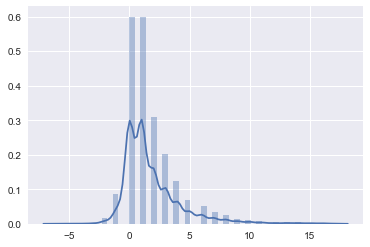

In [49]:
# Removed outliers for visualization purposes
sns.distplot(questions_scores[:int(len(questions_scores)*0.99)])

In [50]:
high_ranked_question_threshold = np.percentile(questions_scores, 90)
high_ranked_question_threshold

5.0

In [51]:
low_ranked_question_threshold = np.percentile(questions_scores, 10)
low_ranked_question_threshold

0.0

## Answers score distribution

In [52]:
answers_scores = sorted(posts_df[(posts_df["post_label"]=="Answer")|(posts_df["post_label"]=="Accepted answer")]["Score"])

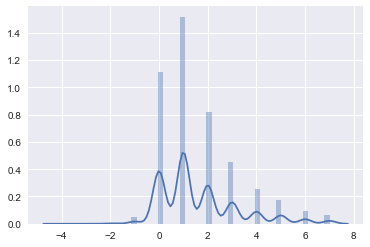

In [53]:
sns.distplot(answers_scores[:int(len(answers_scores)*0.95)])

In [54]:
high_ranked_answers_threshold = np.percentile(answers_scores, 90)
high_ranked_answers_threshold

5.0

In [55]:
low_ranked_answers_threshold = np.percentile(answers_scores, 10)
low_ranked_answers_threshold

0.0

## Label the posts rank

In [56]:
def get_post_rank(post_label,post_score):
    if post_label=="Question":
        if post_score>=high_ranked_question_threshold:
            return "High"
        elif post_score<=low_ranked_question_threshold:
            return "Low"
        else:
            return "Normal"
    else:
        if post_score>=high_ranked_answers_threshold:
            return "High"
        elif post_score<=low_ranked_answers_threshold:
            return "Low"
        else:
            return "Normal"

In [57]:
posts_df["post_rank"] = [get_post_rank(post_label,post_score) for post_label,post_score in zip(posts_df["post_label"],posts_df["Score"])]
posts_df['post_rank'].value_counts()

Normal    11477
Low        5334
High       2257
Name: post_rank, dtype: int64

## Stractural feature extraction

In [58]:
pos_tags = ["CC","CD","DT","EX","FW","IN","JJ","JJR","JJS","LS","MD","NN","NNS","NNP","NNPS","PDT","POS","PRP","PRP$","RB","RBR","RBS","RP","SYM","TO","UH","VB","VBD","VBG","VBN","VBP","VBZ","WDT","WP","WP$","WRB"]

In [59]:
question_feature_names = ["text_length","number_of_links","code_percentage"]
for tag in pos_tags:
    question_feature_names.append("%s_count"%tag)

In [60]:
def extract_stractural_features(df):
    df["text_length"] = df["Body"].map(lambda x: len(x)) + df["Body_Code"].map(lambda x: len(x))
    df["number_of_links"] = df["Body"].map(lambda x: x.count("http://"))
    df["code_percentage"] = df["Body_Code"].map(lambda x: len(x)) / df["text_length"]
    pos_counts = posts_df["Body"].map(lambda body: Counter([x[1] for x in pos_tag(word_tokenize(body))]))
    for tag in pos_tags:
        df["%s_count"%tag] = pos_counts.map(lambda x:x[tag])     

In [ ]:
extract_stractural_features(posts_df)

In [ ]:
posts_df

In [62]:
def extract_answer_only_stractural_features(posts_df):
    question_answers_join = pd.merge(posts_df, posts_df,  how='left', left_on=['Id'], right_on = ['ParentId'])
    posts_df["text_length_ratio"] = question_answers_join.apply(lambda x: x["text_length_x"]/x["text_length_y"],axis=1)
    posts_df["code_length_ratio"] = question_answers_join.apply(lambda x: 0 if ((x["Body_Code_y"] is np.nan) or (len(x["Body_Code_x"])==0) or (len(x["Body_Code_y"]))==0) else len(x["Body_Code_x"])/len(x["Body_Code_y"]),axis=1)
    posts_df["response_time_difference"] = question_answers_join.apply(lambda x: x["CreationDate_y"]-x["CreationDate_x"],axis=1)

In [63]:
extract_answer_only_stractural_features(posts_df)

## Complicated features

In [64]:
vectorizer = TfidfVectorizer(sublinear_tf=True,
                                 stop_words='english',analyzer='word')
tf = vectorizer.fit_transform(posts_df["Body"])
posts_df["tf_idf"] = tf

In [65]:
number_of_topics = 150
posts_df["Tags"] = posts_df["Tags"].map(lambda x: [] if (x is np.nan) else x.replace("<","").replace(">",",").strip(",").split(","))
tags = reduce(lambda x,y: x+y,posts_df["Tags"])
tags_freq = Counter(tags)
print(tags_freq.most_common(number_of_topics))

[('machine-learning', 2854), ('python', 1253), ('neural-network', 1168), ('deep-learning', 882), ('classification', 867), ('r', 711), ('data-mining', 613), ('scikit-learn', 505), ('nlp', 486), ('clustering', 443), ('predictive-modeling', 436), ('dataset', 413), ('keras', 378), ('time-series', 353), ('tensorflow', 344), ('regression', 339), ('text-mining', 316), ('statistics', 305), ('bigdata', 285), ('feature-selection', 236), ('visualization', 235), ('convnet', 217), ('random-forest', 214), ('pandas', 210), ('algorithms', 208), ('svm', 201), ('data-cleaning', 196), ('logistic-regression', 188), ('decision-trees', 181), ('data', 178), ('recommender-system', 165), ('xgboost', 157), ('linear-regression', 156), ('rnn', 152), ('apache-spark', 150), ('feature-extraction', 149), ('image-classification', 147), ('k-means', 126), ('cross-validation', 121), ('reinforcement-learning', 113), ('optimization', 110), ('multiclass-classification', 110), ('feature-engineering', 110), ('gradient-descent

In [66]:
topics_indexes = {x[0]:index for index,x in enumerate(tags_freq.most_common(number_of_topics))}

In [ ]:
def get_topic_labels(x):
    labels = np.zeros(len(topics_indexes))
    indexes = []
    for topic in x:
        if topic in topics_indexes:
            indexes.append(topics_indexes[topic])
    labels[indexes] = 1
    return labels
posts_df["topics_labels"] = posts_df["Tags"].map(get_topic_labels)

In [ ]:
#lda = LDA(n_components=number_of_topics).fit(posts_df["Body"],posts_df["topics_labels"])

# Create user related features

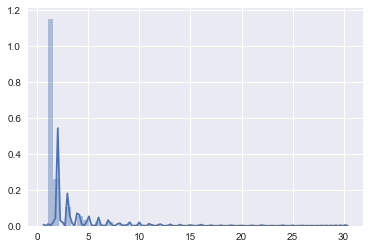

In [67]:
post_to_user_map = {k:v for k,v in zip(posts_df['Id'],posts_df['OwnerUserId'])}
user_to_num_of_posts_map = Counter(list(post_to_user_map.values()))
post_counts=sorted(list(user_to_num_of_posts_map.values()))
sns.distplot(post_counts[:int(len(post_counts)*0.99)])

## Calculate number of posts per user (prior to the given post)

In [68]:
user_to_number_of_posts_map={}
user_number_of_past_posts=[]
for index,row in posts_df.sort_values('CreationDate').iterrows():
    user_id = row['OwnerUserId']
    if user_id not in user_to_number_of_posts_map:
        user_to_number_of_posts_map[user_id] = 1
        user_number_of_past_posts.append(0)
    else:
        user_number_of_past_posts.append(user_to_num_of_posts_map[user_id])
        user_to_num_of_posts_map[user_id] += 1
posts_df['number_of_past_user_posts'] = user_number_of_past_posts

## Calculate number of accepted answers per user (prior to the given post)

In [ ]:
user_to_number_of_accepted_answers_map={}
l=[]
for index,row in posts_df.sort_values('CreationDate').iterrows():
    user_id = row['OwnerUserId']
    if user_id not in user_to_number_of_accepted_answers_map:
        l.append(0)
    else:
        l.append(user_to_number_of_accepted_answers_map[user_id])
    if row['post_label'] == 'Accepted answer':
        if user_id not in user_to_number_of_accepted_answers_map:
            user_to_number_of_accepted_answers_map[user_id] = 0
        user_to_number_of_accepted_answers_map[user_id]+=1
posts_df['number_of_past_accepted_answers'] = l

## Calculate user degrees
* Degrees are number of users that the given user has communicated with

In [ ]:
g = nx.Graph()
for index,row in posts_df[posts_df['post_label']!='Question'].iterrows():
    try:
        g.add_edge(row['OwnerUserId'],post_to_user_map[row['ParentId']])
    except:
        pass

nodes_degrees={}
for n in g.nodes():
    nodes_degrees[n] = g.degree(n)
degrees=[]
for user_id in posts_df['OwnerUserId']:
    try:
        degrees.append(nodes_degrees[user_id])
    except:
        degrees.append(0)
posts_df['user_degree']=degrees

## Calculate node betweeness

In [109]:
graph_betweeness = nx.betweenness_centrality(g)

In [112]:
betweeness=[]
for user_id in posts_df['OwnerUserId']:
    try:
        betweeness.append(graph_betweeness[user_id])
    except:
        betweeness.append(0)
posts_df['betweeness'] = betweeness

## find whether a user is a member of a certain clique

In [125]:
clique_members=[]
for clique in nx.find_cliques(g):
    if len(clique)>2:
        clique_members.extend(clique)
clique_members=list(set(clique_members))
is_clique_member=[]
for u_id in posts_df['OwnerUserId']:
    if u_id in clique_members:
        is_clique_member.append(1)
    else:
        is_clique_member.append(0)
posts_df['is_clique_member'] = is_clique_member